In [1]:
import math
import cv2
import numpy as np
import os
from glob import glob
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
DEBUG = False

In [2]:
cv2.__version__

'3.4.2'

In [39]:
def deskew(im, max_skew=10):
    height, width, rgb = im.shape

    # Create a grayscale image and denoise it
    im_gs = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    im_gs = cv2.fastNlMeansDenoising(im_gs, h=3)

    # Create an inverted B&W copy using Otsu (automatic) thresholding
    im_bw = cv2.threshold(im_gs, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

    # Detect lines in this image. Parameters here mostly arrived at by trial and error.
    lines = cv2.HoughLinesP(
        im_bw, 1, np.pi / 180, 200, minLineLength=width / 3, maxLineGap=width / 150
    )

    # Collect the angles of these lines (in radians)
    angles = []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        angles.append(np.arctan2(y2 - y1, x2 - x1))

    # If the majority of our lines are vertical, this is probably a landscape image
    landscape = np.sum([abs(angle) > np.pi / 4 for angle in angles]) > len(angles) / 2

    # Filter the angles to remove outliers based on max_skew
    if landscape:
        angles = [
            angle
            for angle in angles
            if np.deg2rad(90 - max_skew) < abs(angle) < np.deg2rad(90 + max_skew)
        ]
    else:
        angles = [angle for angle in angles if abs(angle) < np.deg2rad(max_skew)]

    print(len(angles))
    if len(angles) < 5:
        # Insufficient data to deskew
        return im

    # Average the angles to a degree offset
    angle_deg = np.rad2deg(np.median(angles))
    print(angle_deg)

    # If this is landscape image, rotate the entire canvas appropriately
    if landscape:
        if angle_deg < 0:
            im = cv2.rotate(im, cv2.ROTATE_90_CLOCKWISE)
            angle_deg += 90
        elif angle_deg > 0:
            im = cv2.rotate(im, cv2.ROTATE_90_COUNTERCLOCKWISE)
            angle_deg -= 90

    # Rotate the image by the residual offset
    M = cv2.getRotationMatrix2D((width / 2, height / 2), angle_deg, 1)
    im = cv2.warpAffine(im, M, (width, height), borderMode=cv2.BORDER_REPLICATE)
    return im

(3300, 2200, 3)
13
-88.99066503696108


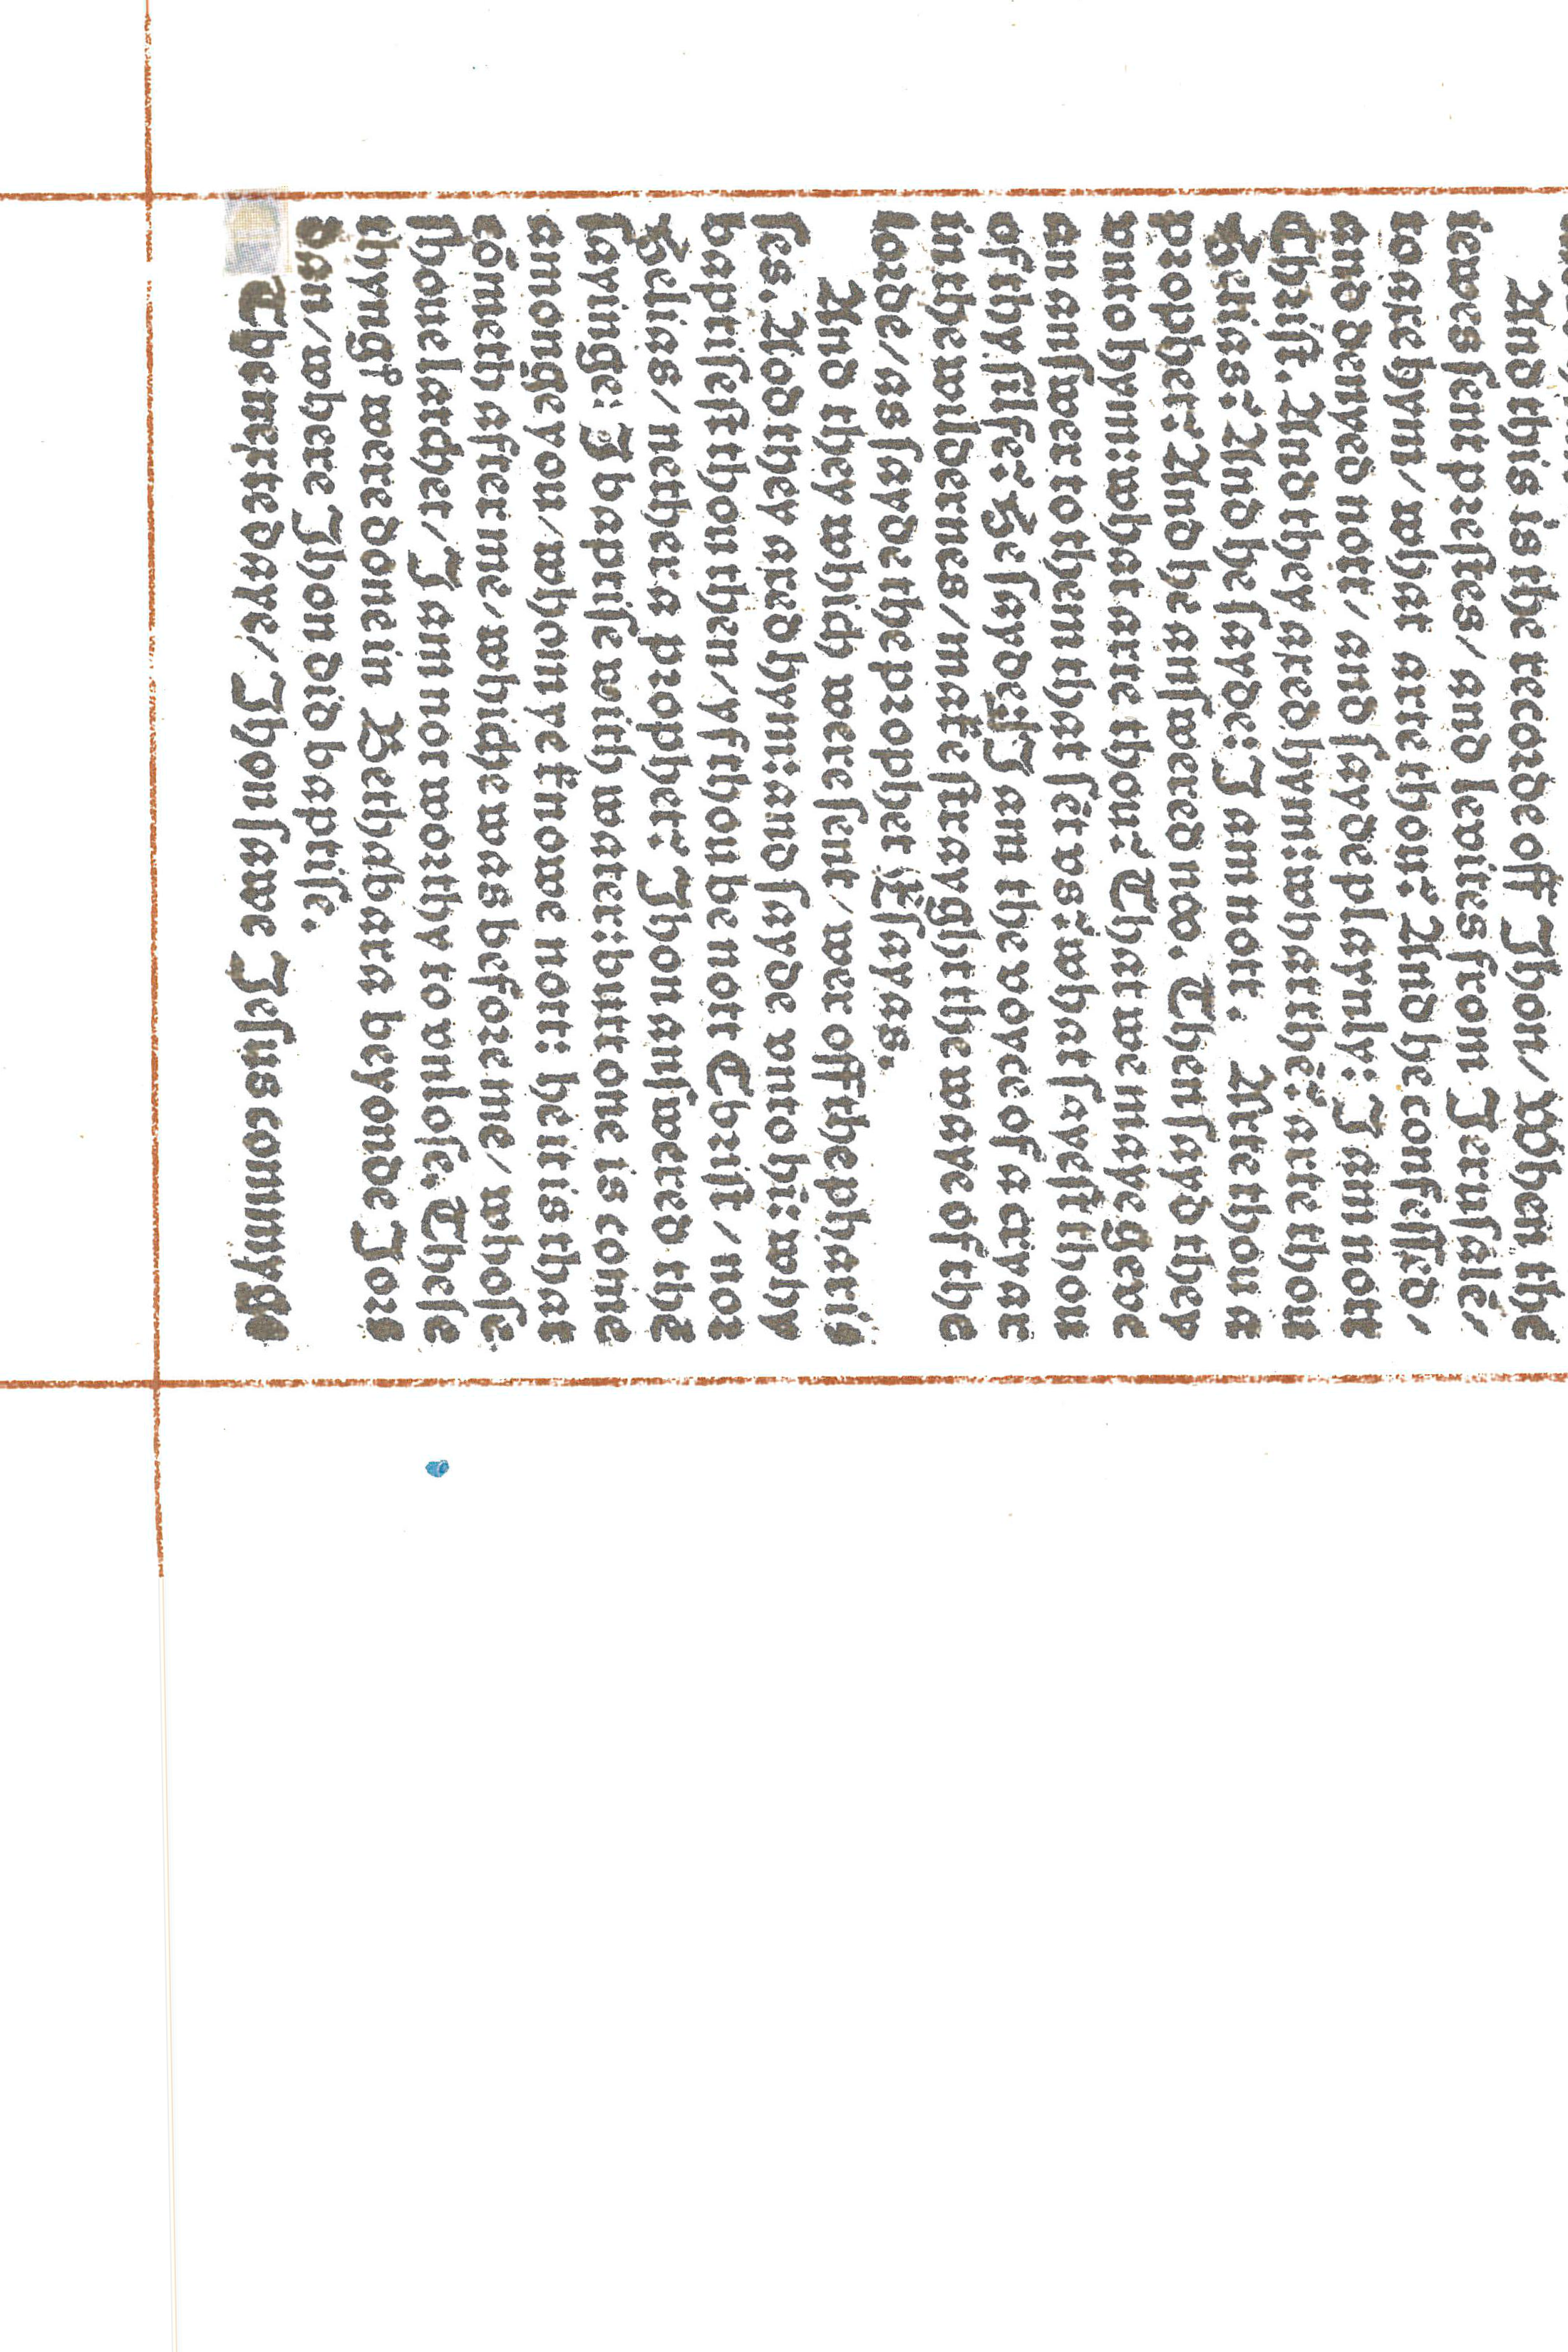

In [40]:
img = cv2.imread('1.cropped/john0002.jpg')
print(img.shape)
im = deskew(img)
Image.fromarray(im)